In [120]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
torch.manual_seed(1)

In [122]:
BATCH_SIZE = 64

In [123]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder("./cyclegan/results/brats2013_train/trainB", transform=mytransform)

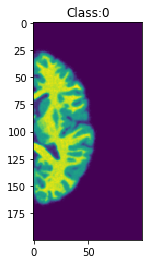

In [82]:
plt.imshow(data[100][0][0].numpy());
plt.title("Class:" + str(data[100][1]));

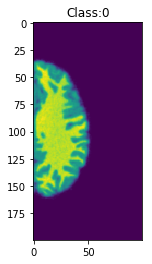

In [83]:
plt.imshow(data[0][0][0].numpy());
plt.title("Class:" + str(data[0][1]));

In [84]:
tosplit = np.asarray(data.imgs)[:,1]
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=0)

In [85]:
print "train_idx", len(train_idx)
print "valid_idx", len(valid_idx)

train_idx 756
valid_idx 252


In [86]:
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx))
valid_loader = torch.utils.data.DataLoader(dataset=data, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx))

In [87]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0])
valid_y = valid_data[0][1]

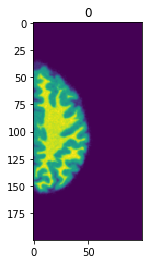

In [88]:
plt.imshow(valid_x[70][0].data.numpy());
plt.title(valid_y[70]);

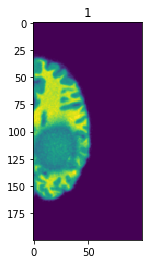

In [89]:
plt.imshow(valid_x[2][0].data.numpy());
plt.title(valid_y[2]);

In [111]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),            
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(), 
            #nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(), 
            #nn.MaxPool2d(kernel_size=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(), 
            #nn.MaxPool2d(kernel_size=2),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        #x = self.bout(x)
        #x = self.dropout1(x)
        output = self.out(x)
        return output, x

In [112]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d (64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d (32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d (16, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=440, out_features=2)
)


In [113]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(200):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x)
        b_y = Variable(y)

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.data[0])
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    accuracy = sum(pred_y == valid_y) / float(valid_y.size(0))
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid accuracy: %.2f' % accuracy)

In [94]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [124]:
checkpoint = torch.load("./classifier_model.pth")
cnn.load_state_dict(checkpoint)

In [125]:
cnn.eval()
test_output, last_layer = cnn(valid_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
accuracy = sum(pred_y == valid_y) / float(valid_y.size(0))
print 'valid accuracy: %.2f' % accuracy

valid accuracy: 0.82


In [126]:
class SubsetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):

        return len(self.indices)


In [102]:
import collections

In [136]:
results = []

for percent in ["0.0", 
                "0.1", 
                "0.2", 
                "0.3", 
                "0.4", 
                "0.5", 
                "0.6", 
                "0.7", 
                "0.8", 
                "0.9", 
                "1.0"]:
    
    path = "./cyclegan/results/brats2013_pix2pix_" + percent + "/test_latest/"
    test_data_raw = torchvision.datasets.ImageFolder(path, transform=mytransform)
    
    labels = np.asarray(["True" in img for img in np.asarray(test_data_raw.imgs)[:,0]])
    fake_b_samples = np.where(["fake_B" in img for img in np.asarray(test_data_raw.imgs)[:,0]])[0]
    real_b_samples = np.where(["real_B" in img for img in np.asarray(test_data_raw.imgs)[:,0]])[0]

    test_fake_b_loader = torch.utils.data.DataLoader(dataset=test_data_raw, batch_size=len(test_data_raw), shuffle=False, 
                                              sampler=SubsetSampler(fake_b_samples))
    
    test_fake_b_data = list(test_fake_b_loader)
    test_fake_b_x = Variable(test_fake_b_data[0][0])
    test_fake_b_y = test_fake_b_data[0][1]
    
    cnn.eval()
    r = cnn(test_fake_b_x)

    pred_y = torch.max(r[0], 1)[1].data.squeeze().numpy()
    
    acc = (pred_y == labels[fake_b_samples]).mean()
    
    dist_0 = pred_y[labels[fake_b_samples] == 0].mean()
    dist_1 = pred_y[labels[fake_b_samples] == 1].mean()

    results.append([percent, pred_y.mean(), acc, dist_0, dist_1, collections.Counter(pred_y)])
    
    print "Percent:", percent," Tumors:", pred_y.mean(), " ", collections.Counter(pred_y)

Percent: 0.0  Tumors: 0.43521594684385384   Counter({0: 170, 1: 131})
Percent: 0.1  Tumors: 0.5514950166112956   Counter({1: 166, 0: 135})
Percent: 0.2  Tumors: 0.5714285714285714   Counter({1: 172, 0: 129})
Percent: 0.3  Tumors: 0.5548172757475083   Counter({1: 167, 0: 134})
Percent: 0.4  Tumors: 0.5514950166112956   Counter({1: 166, 0: 135})
Percent: 0.5  Tumors: 0.5681063122923588   Counter({1: 171, 0: 130})
Percent: 0.6  Tumors: 0.5581395348837209   Counter({1: 168, 0: 133})
Percent: 0.7  Tumors: 0.5548172757475083   Counter({1: 167, 0: 134})
Percent: 0.8  Tumors: 0.5514950166112956   Counter({1: 166, 0: 135})
Percent: 0.9  Tumors: 0.5714285714285714   Counter({1: 172, 0: 129})
Percent: 1.0  Tumors: 0.574750830564784   Counter({1: 173, 0: 128})


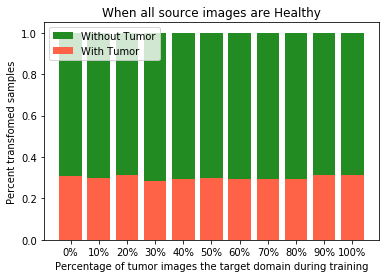

In [137]:
perc = np.asarray(results)[:,3].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images are Healthy"); # (GT=False)
plt.legend(loc="upper left");

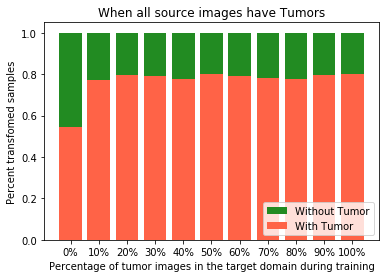

In [138]:
perc = np.asarray(results)[:,4].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images in the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images have Tumors"); # (GT=False)
plt.legend(loc="lower right");

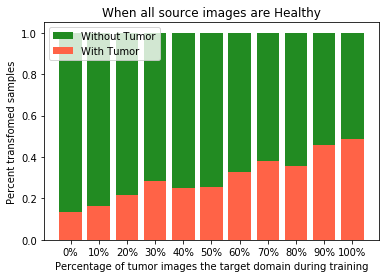

In [692]:
perc = np.asarray(results)[:,3].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images are Healthy"); # (GT=False)
plt.legend(loc="upper left")

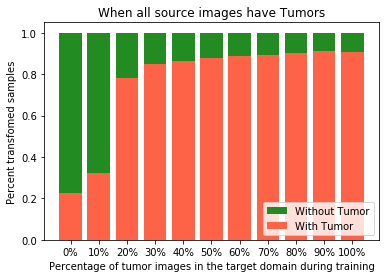

In [693]:
perc = np.asarray(results)[:,4].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images in the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images have Tumors"); # (GT=False)
plt.legend(loc="lower right")

In [695]:
torch.save(cnn.state_dict(), "./classifier_model.pth")